In [6]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

nmgwmdir_cal = Path('../data/Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
workdir = Path('../work')
datadir = Path('../data')
sharedir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')
figdir = Path('../work/figs')
outputdir = Path('../work/output')
autobeldir = Path('../../git_cloned','AutoBEL-v1.0')



# nmgwmdir_uncal = Path('../data/Scenarios/C1/C1-12')
# nmgwmdir_uncal = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/Scenarios/C1/C1-12')
import config
from set_rc import *

import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
import mplleaflet
from  pyproj import Proj
p = Proj(init="epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

In [7]:
import sys
sys.path.append(autobeldir.as_posix())
sys.path.append(autobeldir.joinpath('source_code').as_posix())

import numpy as np
from sklearn.decomposition import PCA

from source_code.combine_mc_samples import *
from source_code.signed_distance_functions import *
from source_code.giip_cal import *
from source_code.scree_plot import scree_plot
from source_code.evd_fast import *
from source_code.gd_wellog_data import gd_wellog_data
from source_code.DGSA_light import DGSA_light
from source_code.gsa_pareto_plt import gsa_pareto_plt
from source_code.falsifications import fals_1Dplt, fals_2Dplt
from source_code.outlier_detection import outlier_2d
from source_code.RobustMD_flsification import RobustMD_flsification
from source_code.rgrplt_all_dh import rgrplt_all_dh
from source_code.cca_and_ccaplt import cca_d_h
from source_code.cca_and_ccaplt import cca_plt
from source_code.gaussianregression_c_dd_star import *
from source_code.post_est_rtn_val import post_est_rtn_val
from source_code.post_est_rtn_val import post_est_clsplt
from source_code.plt_pos_pri_comp import plt_pos_pri_comp
from source_code.plt_MC_models_smpls import m_ensampl_plt
from source_code.plt_MC_models_smpls import mc_samples_plot
from source_code.qc_reslts_plt import m_ensampl_plt


##########################################################################
##          STEP 1.  Analyze prior model samples & extract data          ##
##########################################################################


### Import salinity grid and SEAWAT model mesh

In [8]:
#Name model
modelname = 'test_simpleSWI'
model_ws = workdir.joinpath("test_simpleSWI")
m = flopy.seawat.Seawat.load(model_ws.joinpath(modelname + '.nam').as_posix())
m_empty = flopy.modflow.Modflow.load(model_ws.joinpath('m_empty','m_empty.nam').as_posix())

### Import some shapefiles

In [9]:
f_swi_180 = sharedir.joinpath("chloride_contours",'SWI_180_lines_noz.shp').as_posix()
swi_180 = sf.Reader(f_swi_180)
yrs_180 = [ int(r[-1]) for r in swi_180.records()]

f_swi_400 = sharedir.joinpath("chloride_contours",'SWI_400_lines_noz.shp').as_posix()
swi_400 = sf.Reader(f_swi_400)
yrs_400 = [ int(r[-1]) for r in swi_400.records()]

yr=yrs_180[-1]
yr=yrs_400[-1]

f_shp_180 = sharedir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
f_shp_400 = sharedir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()

### Import salinity data

In [10]:
df_TDS = pd.read_excel(datadir.joinpath('WQ','export_TDS_data.xlsx'))
TDSij =[]
for x,y in zip(df_TDS.X_NAD83_UTM10N.values,df_TDS.Y_NAD83_UTM10N.values):
    try:
        TDSij.append(m_empty.modelgrid.intersect(x,y))
    except:
        TDSij.append((np.nan,np.nan))
df_TDS = df_TDS.assign(rowi=np.array(TDSij)[:,0])
df_TDS = df_TDS.assign(colj=np.array(TDSij)[:,1])

### Import AEM data

In [11]:
df_1719 = pd.read_pickle(datadir.joinpath('AEM','processed_df_1719.pkl'))
df = df_1719.loc[df_1719.skytem_type==304,:]

line = 100501

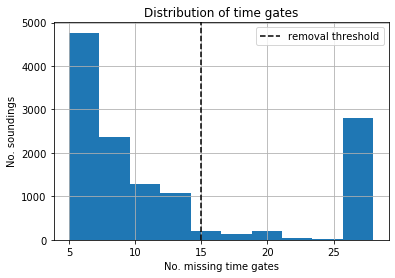

In [12]:
ch1_cols = [c for c in df.columns if c.startswith('DBDT_Ch1')]
ch2_cols = [c for c in df.columns if c.startswith('DBDT_Ch2')]


#Remove soundings with few time gates
thresh = 15
msk = df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.
rm_mask = (df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1) > thresh 
remove_inds = rm_mask[rm_mask==True].index
(df.loc[df.CHANNEL_NO==1,ch1_cols]==9999.).sum(axis=1).hist()
ylims = plt.ylim()
plt.title('Distribution of time gates')
plt.xlabel('No. missing time gates')
plt.ylabel('No. soundings')
plt.vlines(thresh,ylims[0],ylims[1],ls='--',label='removal threshold')
plt.gca().set_ylim(ylims)

plt.legend()
df = df.drop(index=np.r_[remove_inds,remove_inds+1])





In [13]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO==1, df.LINE_NO == line)
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.loc[msk,['LINE_NO']].values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'INVALT'].values[:]
# height = df.loc[msk,'TX_ALTITUDE'].values[:]
system = df.loc[msk,'skytem_type'].values[:]
msk_312 = system==312
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values


print ( 'msk',msk.shape,'\n'
'xy',xy.shape,'\n'
'Line',Line.shape,'\n'
'dem',dem.shape,'\n'
'height',height.shape,'\n'
'system',system.shape,'\n'
'rx_locations',rx_locations.shape,'\n'
'src_locations',src_locations.shape,'\n'
'topo',topo.shape,'\n'
'skytem_type',skytem_type.shape,'\n')

msk (19192,) 
xy (121, 2) 
Line (121, 1) 
dem (121,) 
height (121,) 
system (121,) 
rx_locations (121, 3) 
src_locations (121, 3) 
topo (121, 3) 
skytem_type (19192,) 



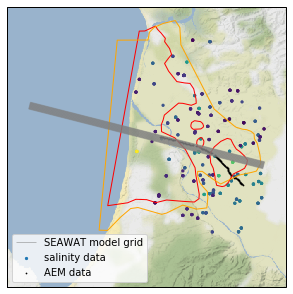

In [18]:
import cartopy

import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

transform = ccrs.UTM(10)

# Create a Stamen terrain background instance.
stamen_terrain = cimgt.Stamen('terrain-background')

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)

ax.add_image(stamen_terrain, 11,alpha=1)

m_empty.modelgrid.plot(ax=ax,linewidth=1,color=[.5,.5,.5,.5],transform=transform,label='SEAWAT model grid')

plt.scatter(df_TDS.X_NAD83_UTM10N,df_TDS.Y_NAD83_UTM10N,s=5,c=np.log10(df_TDS.conc),transform=transform,label='salinity data')


ax.set_extent([596000., 620000.,4052000., 4075962.], crs=transform)


plt.scatter(df.loc[msk,'UTMX'],df.loc[msk,'UTMY'],c='k',s=.5,transform=transform,label='AEM data ')


shp180 =  flopy.plot.plot_shapefile(f_shp_400,ax=ax,transform=transform,                        
                          facecolor='none',edgecolor='r',label='Cl. contour 180-FA')
shp400 =flopy.plot.plot_shapefile(f_shp_180,ax=ax,transform=transform,                        
                          facecolor='none',edgecolor='orange',label='Cl. contour 400-FA')
plt.legend(loc='lower left')

In [19]:
fname = model_ws.joinpath('MT3D001.UCN').as_posix()
anyvals= []
ucnobj = flopy.utils.binaryfile.UcnFile(fname,verbose=False)
# if kstpkper==None:
kstpkpers = ucnobj.get_kstpkper()
kstpkper = kstpkpers[-1]
conc = ucnobj.get_data(kstpkper=kstpkper)


### Define input parameters for Auto-BEL


In [42]:

# model_names: names of the input models, type - list
model_names =['thickness']
# Define model type: 1 - Continous; 2 - Categorical
model_types = [1]
# Define model dimensions in x, y, z directions. 
x_dim, y_dim, z_dim = 200, 100, 1
# Define model horizontal resolution
grid_h_resolution = 250*250
# Provide directory of the prior models
pri_m_samples_dir = 'input/prior_samples/'
# Provide sample size of the prior models
samples_size = 250
# Provide directory of the global parameters
mgl = 'input/thickness_mgl.txt'
# Provide directory of the data observation
dobs_file = 'input/thickness_obs'

In [43]:
print("1. Initialization")
'''Loading and Visualization of prior MC samples'''
m = []
for i in range(len(model_names)):
    m.append(np.load(pri_m_samples_dir + model_names[i] + '.npy'))
    mc_samples_plot(m[i], model_names[i], model_types[
                    i], 'Prior', x_dim, y_dim, z_dim, 1)

'''obtain well trajectory index ("G_d") from dobs_file'''
well_path = np.loadtxt(fname=dobs_file, skiprows=1)[:, :3].astype(int)
well_path = well_path.astype(int)
G_d = x_dim * y_dim * \
    (well_path[:, 2] - 1) + (y_dim - well_path[:, 1]) * \
    x_dim + well_path[:, 0] - 1
np.save('output/model/G_d', G_d)
'''Extract prior data samples'''
d = []
for i in range(len(model_names)):
    d.append(m[0][:, G_d])


1. Initialization


FileNotFoundError: [Errno 2] No such file or directory: 'input/prior_samples/thickness.npy'

##########################################################################
##            STEP 2.  Prior prediction              ##
##########################################################################


In [ ]:
print("  ")
print("2. Prior prediction")
GIIP = GIIP_cal(1, 0, m[0], grid_h_resolution, True)
np.save('output/prediction/GIIP_pri', GIIP)



##########################################################################
##           STEP 3.  Dimension Reduction of data & model       ##
##########################################################################


In [ ]:

print("  ")
print("3. Dimension reduction of model and data")
'''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''
m_pcnums = []
for i in range(len(model_names)):
m_pri = m[i]
d_pri = d[i]

m_pcnum = scree_plot(m_pri, 'model', 90, 'plot')
m_pcnums.append(m_pcnum)
m_mean_pri = m_pri.mean(axis=0)
m_eigvec_pri = evd_fast(m_pri, len(m_pri))
m_pcscr_pri = (m_pri - m_mean_pri).dot(m_eigvec_pri)

np.save('output/model/' + model_names[i] + '_mean_pri', m_mean_pri)
np.save('output/model/' + model_names[i] + '_eigvec_pri', m_eigvec_pri)
np.save('output/model/' + model_names[i] + '_pcscr_pri', m_pcscr_pri)
print("QC of the model eigen images")
eigen_imgs(m_eigvec_pri, [1, 3, 5, 10], x_dim, y_dim)

d_obs = np.loadtxt(fname=dobs_file, skiprows=1)[
    :, 3 + i:4 + i].astype(int).T
d_pca = PCA(n_components=d_pri.shape[1])
d_pca.fit(d_pri)
d_pcscr = d_pca.transform(d_pri)
d_pcscr_obs = d_pca.transform(d_obs)
np.save('output/data/dpcscr_pri_' + model_names[i], d_pcscr)
np.save('output/data/dpcscr_obs_' + model_names[i], d_pcscr_obs)
np.save('output/data/dpca_eigenvec_' +
        model_names[i], d_pca.components_)

##########################################################################
##              STEP 4.   Falsification             ##
##########################################################################

In [8]:
print("  ")
print("4. Prior falsification")
for i in range(len(model_names)):
    d_pri = np.load('output/data/dpcscr_pri_' + model_names[i] + '.npy')
    d_obs = np.load('output/data/dpcscr_obs_' + model_names[i] + '.npy')
    RMD_obs, RMD_Qquantile = RobustMD_flsification(
        d_pri, d_obs, model_names[i], True, 95)

    if RMD_obs >= RMD_Qquantile:
        print("  ")
        print("******************************************************")
        print(
            ' >> "' + model_names[i] + '" Prior is falsified! Please re-design your prior <<')
        print("******************************************************")
        return
    print("*******************************")
    print('>> "' + model_names[i] + '" Prior CANNOT be falsified!')
    print("*******************************")



  
4. Prior falsification


SyntaxError: 'return' outside function (<ipython-input-8-e3e879cfd0b5>, line 15)

##########################################################################
##           STEP 5. GSA               ##
##########################################################################


In [9]:
   print("  ")
    print("5. Global Sensitivity anlaysis-DGSA")
    for i in range(len(model_names)):
        m_pcscr_pri = np.load(
            'output/model/' + model_names[i] + '_pcscr_pri.npy')[:, :m_pcnums[i]]
        d_pcscr_pri = np.load(
            'output/data/dpcscr_pri_' + model_names[i] + '.npy')
        headers = []
        for para in range(m_pcnums[i]):
            headers.append('pc' + str(para + 1))
        try:
            SA_measure = DGSA_light(m_pcscr_pri, d_pcscr, headers)
        except Exception as error:
            print(str(error))
        gsa_pareto_plt(SA_measure, model_names[i])
        np.save('output/data/SA_measure_' + model_names[i], SA_measure)



IndentationError: unexpected indent (<ipython-input-9-7492c8ac3f85>, line 2)

##########################################################################
##           STEP 6.  Uncertainty reduction              ##
##########################################################################



In [ ]:
print("  ")
print("6. Unceratinty reduction")
print("  ")
##          STEP 6.1     QC statistical relationships           ##
print("6.1 QC model and data statistical relationships")
for i in range(len(model_names)):
    SA_measure = np.load('output/data/SA_measure_' +
                         model_names[i] + '.npy')[:, 0]
    sensitive_pcnum = np.argwhere(SA_measure > 1)[:len(d_pcscr[1]), 0]

    m_pcscr_pri = np.load(
        'output/model/' + model_names[i] + '_pcscr_pri.npy')[:, :m_pcnums[i]]
    d_pcscr_pri = np.load(
        'output/data/dpcscr_pri_' + model_names[i] + '.npy')
    d_pcscr_obs = np.load(
        'output/data/dpcscr_obs_' + model_names[i] + '.npy')

    rgrplt_all_dh(d_pcscr_pri, m_pcscr_pri, d_pcscr_obs,
                  [1, 2, 3], [1, 2, 3, 4, 5, 6, 7])

    m_star = m_pcscr_pri[:, sensitive_pcnum]
    d_star = d_pcscr_pri
    dobs_star = d_pcscr_obs
    #######################################################################
    ##          STEP 6.2  CCA             ##
    print("  ")
    print("6.2 Canonical Corrleation Analysis")

    d_c, m_c, ad, am = cca_d_h(d_star, m_star, len(m_star[0, :]))
    dobs_c = np.matmul(dobs_star, ad)
    d_c = np.matmul(d_star, ad)
    m_c = np.matmul(m_star, am)
    cca_plt(d_c, m_c, dobs_c, 1)

    #######################################################################
    ##          STEP 6.3 Gaussian Regression                ##
    print("  ")
    print("6.3 Parametric Gaussian Regression & posterior sampling")

    #######################################################################
    ##          STEP 6.4 Reconstruct posterior model                ##
    err_levl = 0.00
    dpca_eigenvec = np.load(
        'output/data/dpca_eigenvec_' + model_names[i] + '.npy')
    cdd_star = cal_c_dd_star_pca_cca(dpca_eigenvec, ad, err_levl, d_obs)
    post_est_clsplt([1, 2, 3, 4], m_c, d_c, dobs_c, cdd_star, 2, 2)

    print("  ")
    print("6.4 Reconstruct posterior model")
    all_mc_post = []
    for cca_comp in range(1, len(m_star[0, :]) + 1):
        all_mc_post.append(post_est_rtn_val(
            cca_comp, m_c, d_c, dobs_c, cdd_star, 0))
    all_mc_post = np.asarray(all_mc_post).T
    m_pcscr_post_SA = all_mc_post.dot(np.linalg.inv(am))
    m_pcscr_post = np.load(
        'output/model/' + model_names[i] + '_pcscr_pri.npy')
    m_pcscr_post[:, sensitive_pcnum] = m_pcscr_post_SA
    plt_pos_pri_comp(
        sensitive_pcnum[0] + 1, sensitive_pcnum[1] + 1, m_pcscr_pri, m_pcscr_post)

    m_eigvec = np.load('output/model/' +
                       model_names[i] + '_eigvec_pri.npy')
    m_pri_mean = np.load(
        'output/model/' + model_names[i] + '_mean_pri.npy')
    m_post = m_pcscr_post.dot(m_eigvec.T) + m_pri_mean
    np.save('output/model/' + model_names[i] + '_model_post', m_post)

    #######################################################################
    ##          STEP 6.5 QC posterior results               ##

    print("  ")
    print("6.5. QC posterior results")
    print("  ")
    print("6.5.1 Plot posterior models")
    m_pri = np.load(pri_m_samples_dir + model_names[i] + '.npy')
    d_obs = np.c_[np.loadtxt(fname=dobs_file, skiprows=1)[:, :3], np.loadtxt(
        fname=dobs_file, skiprows=1)[:, i + 3:i + 4]]
    # m_sampls_plt(m_post, samples_size, model_names[i], x_dim, y_dim, z_dim)
    mc_samples_plot(m_post, model_names[i], model_types[
                    i], 'Posterior', x_dim, y_dim, z_dim, 1)
    m_ensampl_plt(m_post, m_pri,  model_names[
                  i], 1, x_dim, y_dim, 1, d_obs)

    print("  ")
    print("6.5.2 Calculate posterior prediction")
    GIIP_post = GIIP_cal(1, 0, m_post, grid_h_resolution, False)
    np.save('output/prediction/GIIP_post', GIIP_post)
    GIIP_pri = np.load('output/prediction/GIIP_pri.npy')
    giip_compare(GIIP_pri, GIIP_post, model_names[i])

print("  ")
print("AUTO-BEL completed :-)!")

In [ ]:



def Auto_BEL(pri_m_samples_dir, model_names, model_types, mgl, samples_size, x_dim, y_dim, z_dim, grid_h_resolution, dobs_file):
    '''This is the main function for runing Auto_BEL'''
    ##########################################################################
    ##          STEP 1.  Analyze prior model samples & extract data          ##
    ##########################################################################
    print("1. Initialization")
    '''Loading and Visualization of prior MC samples'''
    m = []
    for i in range(len(model_names)):
        m.append(np.load(pri_m_samples_dir + model_names[i] + '.npy'))
        mc_samples_plot(m[i], model_names[i], model_types[
                        i], 'Prior', x_dim, y_dim, z_dim, 1)

    '''obtain well trajectory index ("G_d") from dobs_file'''
    well_path = np.loadtxt(fname=dobs_file, skiprows=1)[:, :3].astype(int)
    well_path = well_path.astype(int)
    G_d = x_dim * y_dim * \
        (well_path[:, 2] - 1) + (y_dim - well_path[:, 1]) * \
        x_dim + well_path[:, 0] - 1
    np.save('output/model/G_d', G_d)
    '''Extract prior data samples'''
    d = []
    for i in range(len(model_names)):
        d.append(m[0][:, G_d])

    ##########################################################################
        ##            STEP 2.  Prior prediction              ##
    ##########################################################################
    print("  ")
    print("2. Prior prediction")
    GIIP = GIIP_cal(1, 0, m[0], grid_h_resolution, True)
    np.save('output/prediction/GIIP_pri', GIIP)

    ##########################################################################
    ##           STEP 3.  Dimension Reduction of data & model       ##
    ##########################################################################

    print("  ")
    print("3. Dimension reduction of model and data")
    '''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''
    m_pcnums = []
    for i in range(len(model_names)):
        m_pri = m[i]
        d_pri = d[i]

        m_pcnum = scree_plot(m_pri, 'model', 90, 'plot')
        m_pcnums.append(m_pcnum)
        m_mean_pri = m_pri.mean(axis=0)
        m_eigvec_pri = evd_fast(m_pri, len(m_pri))
        m_pcscr_pri = (m_pri - m_mean_pri).dot(m_eigvec_pri)

        np.save('output/model/' + model_names[i] + '_mean_pri', m_mean_pri)
        np.save('output/model/' + model_names[i] + '_eigvec_pri', m_eigvec_pri)
        np.save('output/model/' + model_names[i] + '_pcscr_pri', m_pcscr_pri)
        print("QC of the model eigen images")
        eigen_imgs(m_eigvec_pri, [1, 3, 5, 10], x_dim, y_dim)

        d_obs = np.loadtxt(fname=dobs_file, skiprows=1)[
            :, 3 + i:4 + i].astype(int).T
        d_pca = PCA(n_components=d_pri.shape[1])
        d_pca.fit(d_pri)
        d_pcscr = d_pca.transform(d_pri)
        d_pcscr_obs = d_pca.transform(d_obs)
        np.save('output/data/dpcscr_pri_' + model_names[i], d_pcscr)
        np.save('output/data/dpcscr_obs_' + model_names[i], d_pcscr_obs)
        np.save('output/data/dpca_eigenvec_' +
                model_names[i], d_pca.components_)

    ##########################################################################
        ##              STEP 4.   Falsification             ##
    ##########################################################################
    print("  ")
    print("4. Prior falsification")
    for i in range(len(model_names)):
        d_pri = np.load('output/data/dpcscr_pri_' + model_names[i] + '.npy')
        d_obs = np.load('output/data/dpcscr_obs_' + model_names[i] + '.npy')
        RMD_obs, RMD_Qquantile = RobustMD_flsification(
            d_pri, d_obs, model_names[i], True, 95)

        if RMD_obs >= RMD_Qquantile:
            print("  ")
            print("******************************************************")
            print(
                ' >> "' + model_names[i] + '" Prior is falsified! Please re-design your prior <<')
            print("******************************************************")
            return
        print("*******************************")
        print('>> "' + model_names[i] + '" Prior CANNOT be falsified!')
        print("*******************************")

    ##########################################################################
        ##           STEP 5. GSA               ##
    ##########################################################################
    print("  ")
    print("5. Global Sensitivity anlaysis-DGSA")
    for i in range(len(model_names)):
        m_pcscr_pri = np.load(
            'output/model/' + model_names[i] + '_pcscr_pri.npy')[:, :m_pcnums[i]]
        d_pcscr_pri = np.load(
            'output/data/dpcscr_pri_' + model_names[i] + '.npy')
        headers = []
        for para in range(m_pcnums[i]):
            headers.append('pc' + str(para + 1))
        try:
            SA_measure = DGSA_light(m_pcscr_pri, d_pcscr, headers)
        except Exception as error:
            print(str(error))
        gsa_pareto_plt(SA_measure, model_names[i])
        np.save('output/data/SA_measure_' + model_names[i], SA_measure)

    ##########################################################################
        ##           STEP 6.  Uncertainty reduction              ##
    ##########################################################################
    print("  ")
    print("6. Unceratinty reduction")
    print("  ")
    ##########################################################################
    ##          STEP 6.1     QC statistical relationships           ##
    print("6.1 QC model and data statistical relationships")
    for i in range(len(model_names)):
        SA_measure = np.load('output/data/SA_measure_' +
                             model_names[i] + '.npy')[:, 0]
        sensitive_pcnum = np.argwhere(SA_measure > 1)[:len(d_pcscr[1]), 0]

        m_pcscr_pri = np.load(
            'output/model/' + model_names[i] + '_pcscr_pri.npy')[:, :m_pcnums[i]]
        d_pcscr_pri = np.load(
            'output/data/dpcscr_pri_' + model_names[i] + '.npy')
        d_pcscr_obs = np.load(
            'output/data/dpcscr_obs_' + model_names[i] + '.npy')

        rgrplt_all_dh(d_pcscr_pri, m_pcscr_pri, d_pcscr_obs,
                      [1, 2, 3], [1, 2, 3, 4, 5, 6, 7])

        m_star = m_pcscr_pri[:, sensitive_pcnum]
        d_star = d_pcscr_pri
        dobs_star = d_pcscr_obs
        #######################################################################
        ##          STEP 6.2  CCA             ##
        print("  ")
        print("6.2 Canonical Corrleation Analysis")

        d_c, m_c, ad, am = cca_d_h(d_star, m_star, len(m_star[0, :]))
        dobs_c = np.matmul(dobs_star, ad)
        d_c = np.matmul(d_star, ad)
        m_c = np.matmul(m_star, am)
        cca_plt(d_c, m_c, dobs_c, 1)

        #######################################################################
        ##          STEP 6.3 Gaussian Regression                ##
        print("  ")
        print("6.3 Parametric Gaussian Regression & posterior sampling")

        #######################################################################
        ##          STEP 6.4 Reconstruct posterior model                ##
        err_levl = 0.00
        dpca_eigenvec = np.load(
            'output/data/dpca_eigenvec_' + model_names[i] + '.npy')
        cdd_star = cal_c_dd_star_pca_cca(dpca_eigenvec, ad, err_levl, d_obs)
        post_est_clsplt([1, 2, 3, 4], m_c, d_c, dobs_c, cdd_star, 2, 2)

        print("  ")
        print("6.4 Reconstruct posterior model")
        all_mc_post = []
        for cca_comp in range(1, len(m_star[0, :]) + 1):
            all_mc_post.append(post_est_rtn_val(
                cca_comp, m_c, d_c, dobs_c, cdd_star, 0))
        all_mc_post = np.asarray(all_mc_post).T
        m_pcscr_post_SA = all_mc_post.dot(np.linalg.inv(am))
        m_pcscr_post = np.load(
            'output/model/' + model_names[i] + '_pcscr_pri.npy')
        m_pcscr_post[:, sensitive_pcnum] = m_pcscr_post_SA
        plt_pos_pri_comp(
            sensitive_pcnum[0] + 1, sensitive_pcnum[1] + 1, m_pcscr_pri, m_pcscr_post)

        m_eigvec = np.load('output/model/' +
                           model_names[i] + '_eigvec_pri.npy')
        m_pri_mean = np.load(
            'output/model/' + model_names[i] + '_mean_pri.npy')
        m_post = m_pcscr_post.dot(m_eigvec.T) + m_pri_mean
        np.save('output/model/' + model_names[i] + '_model_post', m_post)

        #######################################################################
        ##          STEP 6.5 QC posterior results               ##

        print("  ")
        print("6.5. QC posterior results")
        print("  ")
        print("6.5.1 Plot posterior models")
        m_pri = np.load(pri_m_samples_dir + model_names[i] + '.npy')
        d_obs = np.c_[np.loadtxt(fname=dobs_file, skiprows=1)[:, :3], np.loadtxt(
            fname=dobs_file, skiprows=1)[:, i + 3:i + 4]]
        # m_sampls_plt(m_post, samples_size, model_names[i], x_dim, y_dim, z_dim)
        mc_samples_plot(m_post, model_names[i], model_types[
                        i], 'Posterior', x_dim, y_dim, z_dim, 1)
        m_ensampl_plt(m_post, m_pri,  model_names[
                      i], 1, x_dim, y_dim, 1, d_obs)

        print("  ")
        print("6.5.2 Calculate posterior prediction")
        GIIP_post = GIIP_cal(1, 0, m_post, grid_h_resolution, False)
        np.save('output/prediction/GIIP_post', GIIP_post)
        GIIP_pri = np.load('output/prediction/GIIP_pri.npy')
        giip_compare(GIIP_pri, GIIP_post, model_names[i])

    print("  ")
    print("AUTO-BEL completed :-)!")
    return
